# Generate a box plot from sample data in aviris of sentinel-1 values in kelp, ocean, and waves at different tidal states

### Melanie Lin and Cami Pawlak 7/30/2025

#### import packages

In [11]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import pandas as pd
import numpy as np
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#### Set paths

In [12]:
import os

# Get current home directory of the user
home_dir = os.path.expanduser("~")
print("Home directory:", home_dir)

# Change current working directory to home
os.chdir(home_dir)
os.chdir(r"shared-public/NASA-SARP/west_coast_students/oceans/Melanie/")

# Confirm
print("Now working in:", os.getcwd())

Home directory: /home/jovyan
Now working in: /home/jovyan/shared-public/NASA-SARP/west_coast_students/oceans/Melanie


In [13]:
#Suiderstrand
#kelp
kelp_ss_path = r"data/data/suiderstrand/shapefiles/kelp_suiderstrand_2023_11_09.shp"
#ocean
ocean_ss_path = r"data/data/suiderstrand/shapefiles/ocean_suiderstrand_2023_11_09.shp"
#waves
waves_ss_path = r"data/data/suiderstrand/shapefiles/waves_suiderstrand_2023_11_09.shp"
#vv
vv_ss_path = r"data/data/suiderstrand/rasters/sentinel_1_VV_suiderstrand_2023_11_08.tif"
#vh
vh_ss_path = r"data/data/suiderstrand/rasters/sentinel_1_VH_suiderstrand_2023_11_08.tif"


In [14]:
#Betty's Bay
#kelp
kelp_bb_path = r"data/data/bettys_bay/shapefiles/kelp_bettys_bay_2023_10_29.shp"

ocean_bb_path = r"data/data/bettys_bay/shapefiles/ocean_bettys_bay_2023_10_29.shp"

waves_bb_path = r"data/data/bettys_bay/shapefiles/waves_bettys_bay_2023_10_29.shp"

vv_bb_hightide_path = r"data/data/bettys_bay/rasters/sentinel_1_bettys_bay_VV_high_tide_2023_11_01.tif"

vh_bb_hightide_path = r"data/data/bettys_bay/rasters/sentinel_1_bettys_bay_VH_high_tide_2023_11_01.tif"

vv_bb_lowtide_path = r"data/data/bettys_bay/rasters/sentinel_1_bettys_bay_VV_low_tide_2023_10_27.tif"

vh_bb_lowtide_path = r"data/data/bettys_bay/rasters/sentinel_1_bettys_bay_VH_low_tide_2023_10_27.tif"

#### Make CSVs of raster values per class

In [15]:
#Functions

def extract_pixels_per_band(band_label, raster_path, place):
    rows = []

    for shapefile_label, shapefile_path in shapefile_paths.items():
        gdf = gpd.read_file(shapefile_path)

        with rasterio.open(raster_path) as src:
            raster_crs = src.crs
            nodata_val = src.nodata

            # Reproject to raster CRS if needed
            if gdf.crs != raster_crs:
                gdf = gdf.to_crs(raster_crs)

            for i, row in gdf.iterrows():
                geom = [mapping(row['geometry'])]
                try:
                    out_image, _ = mask(
                        src,
                        geom,
                        crop=True,
                        filled=True,
                        nodata=nodata_val
                    )
                    array = out_image[0]

                    # Filter valid pixels
                    valid_mask = np.ones(array.shape, dtype=bool)
                    if nodata_val is not None:
                        valid_mask &= (array != nodata_val)
                    valid_mask &= (array != 0)

                    pixel_values = array[valid_mask]

                    for val in pixel_values:
                        rows.append({
                            "shapefile": shapefile_label,
                            "feature_id": i,
                            "pixel_value": val
                        })

                except Exception as e:
                    print(f"⚠️ Error processing feature {i} in {shapefile_label} with {band_label}: {e}")
                
    df = pd.DataFrame(rows)
    output_filename = f"{place}_{band_label}_pixel_values.csv"
    df.to_csv(output_filename, index=False)
    print(f"✅ Saved {output_filename}")
    return df



In [16]:
# Betty's Bay
# Set shapefiles
# Load shapefiles
shapefile_paths = {
    "Kelp": kelp_bb_path,
    "Ocean": ocean_bb_path,
    "Waves": waves_bb_path
}

place = "bettys_bay_low_tide"
    
# Run the extraction and save for each band
df_band1 = extract_pixels_per_band("VV", vv_bb_lowtide_path, place)
df_band2 = extract_pixels_per_band("VH", vh_bb_lowtide_path, place)

# Optional: preview
print("\n📊 Band 1 Preview:")
print(df_band1.head())

print("\n📊 Band 2 Preview:")
print(df_band2.head())


✅ Saved bettys_bay_low_tide_VV_pixel_values.csv
✅ Saved bettys_bay_low_tide_VH_pixel_values.csv

📊 Band 1 Preview:
  shapefile  feature_id  pixel_value
0      Kelp           1   -10.465933
1      Kelp           3   -16.891176
2      Kelp           5    -8.761360
3      Kelp           6   -15.510873
4      Kelp           7    -9.504218

📊 Band 2 Preview:
  shapefile  feature_id  pixel_value
0      Kelp           1   -21.365513
1      Kelp           3   -23.913107
2      Kelp           5   -17.905834
3      Kelp           6   -30.673340
4      Kelp           7   -19.058739


In [17]:
# Suiderstrand
# Set shapefiles
# Load shapefiles
shapefile_paths = {
    "Kelp": kelp_ss_path,
    "Ocean": ocean_ss_path,
    "Waves": waves_ss_path
}

place = "suiderstrand"
    
# Run the extraction and save for each band
df_band1 = extract_pixels_per_band("VV", vv_ss_path, place)
df_band2 = extract_pixels_per_band("VH", vh_ss_path, place)

# Optional: preview
print("\n📊 Band 1 Preview:")
print(df_band1.head())

print("\n📊 Band 2 Preview:")
print(df_band2.head())


✅ Saved suiderstrand_VV_pixel_values.csv
✅ Saved suiderstrand_VH_pixel_values.csv

📊 Band 1 Preview:
  shapefile  feature_id  pixel_value
0      Kelp           6   -13.883289
1      Kelp           6   -14.620630
2      Kelp           6   -14.306042
3      Kelp           9   -14.928488
4      Kelp           9   -15.882939

📊 Band 2 Preview:
  shapefile  feature_id  pixel_value
0      Kelp           6   -22.711300
1      Kelp           6   -23.410175
2      Kelp           6   -23.010782
3      Kelp           9   -23.498283
4      Kelp           9   -24.485310


#### Box Plot Creation :-)

/tmp/ipykernel_115/3098636688.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_115/3098636688.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


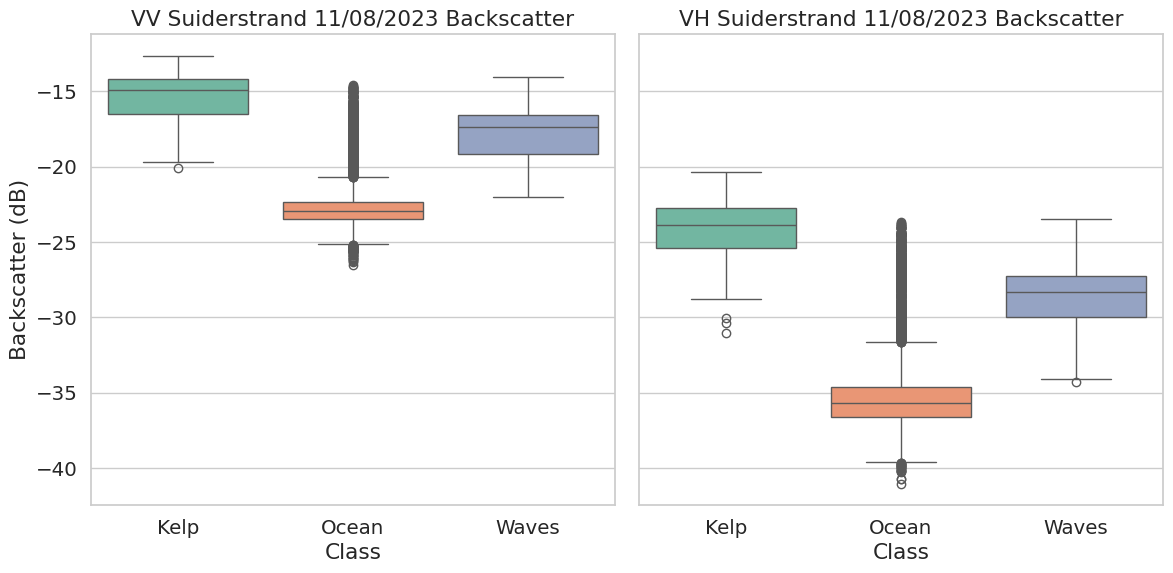

In [18]:
#Suiderstand

# Load the two CSVs
VV = pd.read_csv(r"data/data/suiderstrand/csvs/suiderstrand_VV_pixel_values.csv")
VH = pd.read_csv(r"data/data/suiderstrand/csvs/suiderstrand_VH_pixel_values.csv")

# Set a consistent style
sns.set(style="whitegrid", font_scale=1.3)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Boxplot for SSBand1
sns.boxplot(
    x="shapefile",
    y="pixel_value",
    data=VV,
    palette="Set2",
    ax=axes[0]
)
axes[0].set_title("VV Suiderstrand 11/08/2023 Backscatter")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Backscatter (dB)")

# Boxplot for SSBand2
sns.boxplot(
    x="shapefile",
    y="pixel_value",
    data=VH,
    palette="Set2",
    ax=axes[1]
)
axes[1].set_title("VH Suiderstrand 11/08/2023 Backscatter")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


/tmp/ipykernel_115/1544840079.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_115/1544840079.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_115/1544840079.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_115/1544840079.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(



High Tide VV (1.8 m) means:
shapefile
Kelp    -13.876
Ocean   -16.672
Waves   -14.222
Name: pixel_value, dtype: float64

High Tide VH (1.8 m) means:
shapefile
Kelp    -23.809
Ocean   -33.604
Waves   -24.322
Name: pixel_value, dtype: float64

Low Tide VV (1.3 m) means:
shapefile
Kelp    -10.477
Ocean   -17.204
Waves   -10.399
Name: pixel_value, dtype: float64

Low Tide VH (1.3 m) means:
shapefile
Kelp    -19.215
Ocean   -33.368
Waves   -19.217
Name: pixel_value, dtype: float64


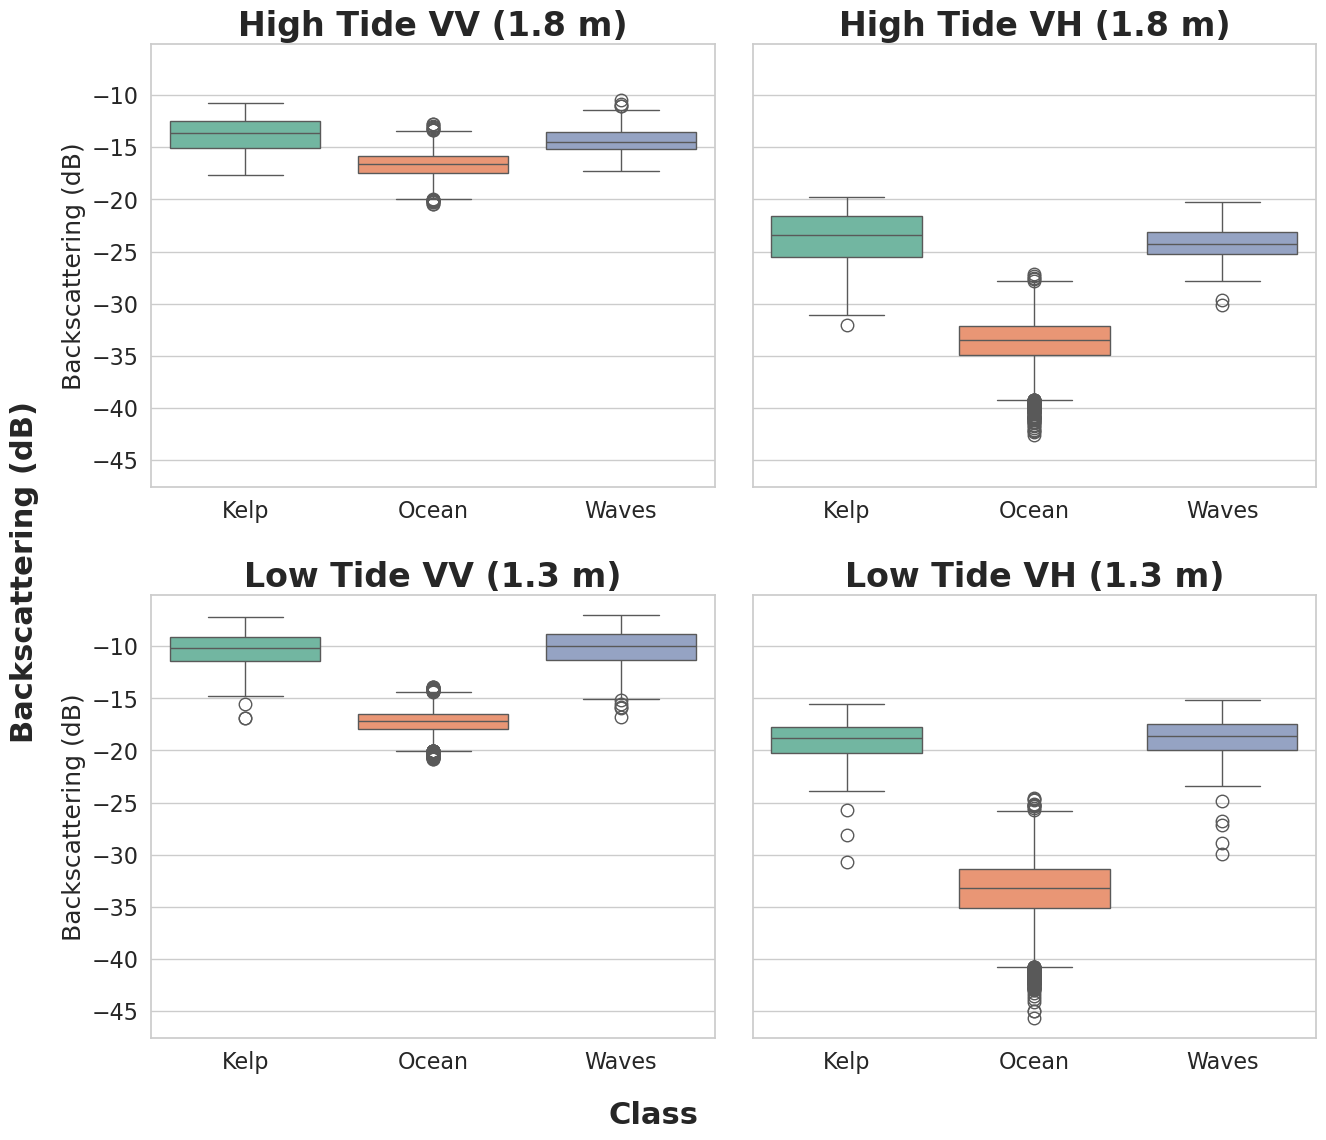

In [19]:
#Betty's Bay

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSVs
df_high_vv = pd.read_csv(r"data/data/bettys_bay/csvs/bettys_bay_high_tide_VV_pixel_values.csv")
df_high_vh = pd.read_csv(r"data/data/bettys_bay/csvs/bettys_bay_high_tide_VH_pixel_values.csv")
df_low_vv  = pd.read_csv(r"data/data/bettys_bay/csvs/bettys_bay_low_tide_VV_pixel_values.csv")
df_low_vh  = pd.read_csv(r"data/data/bettys_bay/csvs/bettys_bay_low_tide_VH_pixel_values.csv")

# Put them into a dict for easier plotting
datasets = {
    "High Tide VV (1.8 m)": df_high_vv,
    "High Tide VH (1.8 m)": df_high_vh,
    "Low Tide VV (1.3 m)": df_low_vv,
    "Low Tide VH (1.3 m)": df_low_vh
}

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharey=True)
axes = axes.flatten()

# Set a general style
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.4)  # makes all fonts larger

# Plot each dataset
for ax, (title, df) in zip(axes, datasets.items()):
    sns.boxplot(
        data=df,
        x="shapefile",
        y="pixel_value",
        ax=ax,
        palette="Set2"
    )
    
    # Print means to console
    means = df.groupby("shapefile")["pixel_value"].mean()
    print(f"\n{title} means:")
    print(means.round(3))  # round to 3 decimals for readability
    
    ax.set_title(title, fontsize=24, weight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Backscattering (dB)", fontsize=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

# Add a global x-axis and y-axis label
fig.text(0.5, 0.04, "Class", ha="center", fontsize=22, weight="bold")
fig.text(0.04, 0.5, "Backscattering (dB)", va="center", rotation="vertical", fontsize=22, weight="bold")

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()


### ANOVA

In [13]:
# Define function to run ANOVA + Tukey
def run_anova(csv_file, title):
    # Load CSV
    df = csv_file #this is actually an object that depends on earlier code being run
    
    # Make sure the column names match your file (adjust if needed)
    # Assumes columns are something like: "shapefile" (Kelp, Ocean, Waves) and "value"
    print(f"\nRunning analysis for {csv_file}...")
    print(df.head())

    # Run one-way ANOVA
    model = ols('pixel_value ~ C(shapefile)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("\nANOVA Results:")
    print(anova_table)

    # Tukey HSD post-hoc
    tukey = pairwise_tukeyhsd(endog=df['pixel_value'],
                              groups=df['shapefile'],
                              alpha=0.05)
    print("\nTukey HSD Post-hoc Results:")
    print(tukey)

run_anova(VV, "Suiderstrand VV")
run_anova(VH, "Suiderstrand VH")
run_anova(df_high_vv, "Betty's Bay High Tide VV")
run_anova(df_high_vh, "Betty's Bay High Tide VH")
run_anova(df_low_vv, "Betty's Bay Low Tide VV")
run_anova(df_low_vh, "Betty's Bay Low Tide VH")


Running analysis for      shapefile  feature_id  pixel_value
0         Kelp           6   -13.883289
1         Kelp           6   -14.620630
2         Kelp           6   -14.306042
3         Kelp           9   -14.928488
4         Kelp           9   -15.882939
...        ...         ...          ...
7816     Waves          39   -17.100403
7817     Waves          39   -17.716927
7818     Waves          39   -17.256758
7819     Waves          39   -17.521130
7820     Waves          39   -17.793810

[7821 rows x 3 columns]...
  shapefile  feature_id  pixel_value
0      Kelp           6   -13.883289
1      Kelp           6   -14.620630
2      Kelp           6   -14.306042
3      Kelp           9   -14.928488
4      Kelp           9   -15.882939

ANOVA Results:
                    sum_sq      df            F  PR(>F)
C(shapefile)   8943.770129     2.0  1913.253895     0.0
Residual      18273.161512  7818.0          NaN     NaN

Tukey HSD Post-hoc Results:
Multiple Comparison of Means - Tuke